## Read the pre-computed global/local keys file
This file, called `key_analysis.txt`, was computed by calling `justkeydding v1.12.0` directly from the bash terminal

```bash
python -m justkeydding --json NAME_OF_THE_FILE
```

The file is structured in pairs of lines. The first line of each pair contains the name of the file. The second one, the `json` output given by `justkeydding v1.12.0`.

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
with open('key_analysis.txt') as fd:
    lines = fd.readlines()

Preprocessing the name of the files so that they are easier to organize

In [3]:
key_numbers = {
    'C': 0, 'C#': 1, 'Db': 1, 'D': 2,
    'D#': 3, 'Eb': 3, 'E': 4, 'F': 5,
    'F#': 6, 'Gb': 6, 'G': 7, 'G#': 8,
    'Ab': 8, 'A': 9, 'A#': 10, 'Bb': 10,
    'B': 11,

    'c': 12, 'c#': 13, 'db': 13, 'd': 14,
    'd#': 15, 'eb': 15, 'e': 16, 'f': 17,
    'f#': 18, 'gb': 18, 'g': 19, 'g#': 20,
    'ab': 20, 'a': 21, 'a#': 22, 'bb': 22,
    'b': 23
}

def parse_filename(f):
    f = f.replace('.musicxml', '').rsplit('_', 1)
    filename, stage = f
    return filename, stage

def encode_key(key_string):
    return key_numbers[key_string]    

Turning the lines into a dictionary

In [4]:
analyses_by_file = {}
for name, analysis in zip(lines[::2], lines[1::2]):
    # Decompose the file name into file name and stage of the workflow
    filename, stage = parse_filename(name.strip())
    # Get the dictionary for this file, if None, create one now 
    columns = analyses_by_file.get(filename, {'local_key_index': []})
    # Turn the json string in the file into a dictionary 
    jsondict = json.loads(analysis.strip())
    # After the json conversion, the time indexes were encoded as string. Converting them to float.
    jsondict['local_keys'] = {float(k): encode_key(v) for k, v in jsondict['local_keys'].items()}
    # The local key index might be different for every stage, get the index of this stage
    local_keys_index = list(jsondict['local_keys'].keys())
    # Add the unique indexes of this stage to the shared local-key index of the file
    general_index = columns['local_key_index']
    general_index = list(sorted(set(general_index + local_keys_index)))
    columns['local_key_index'] = general_index
    columns_with_version = {(k + '_' + stage): v for k, v in jsondict.items()}
    columns.update(columns_with_version)
    analyses_by_file[filename] = columns

Now that everything is in well-organized dictionaries grouped by file, they can be turned into DataFrames

1_op12_1
['c', 'Eb', 'Eb', 'Eb']


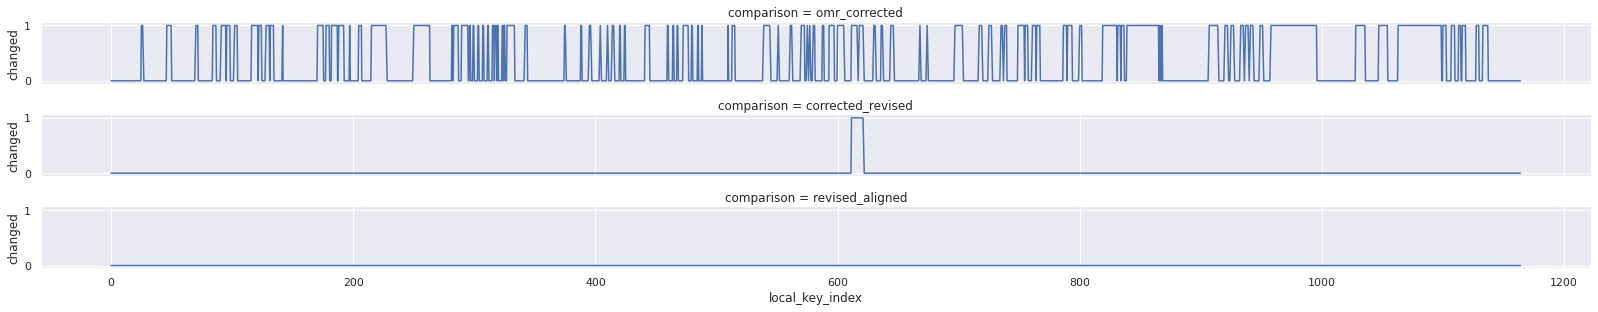

1_op12_2
['G', 'G', 'G', 'G']


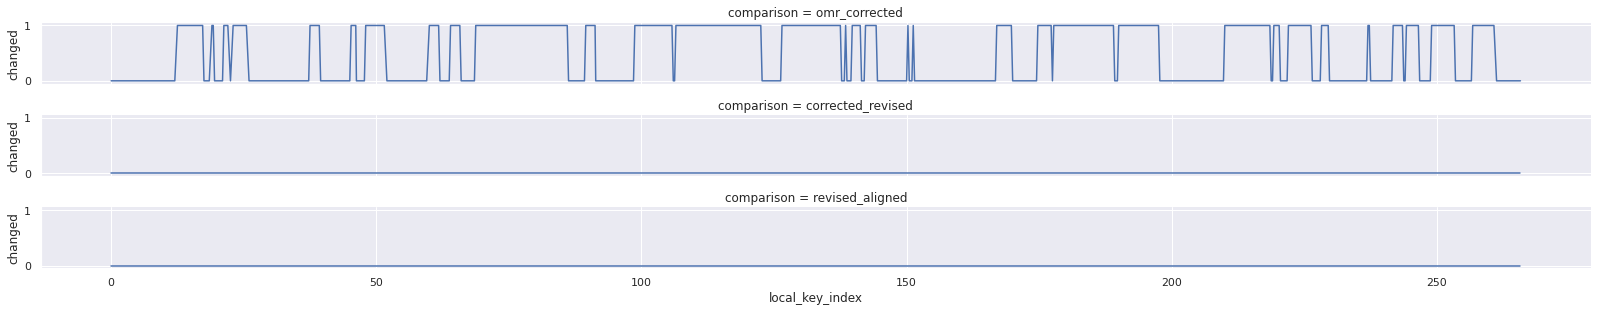

1_op12_3
['Bb', 'Bb', 'Bb', 'Bb']


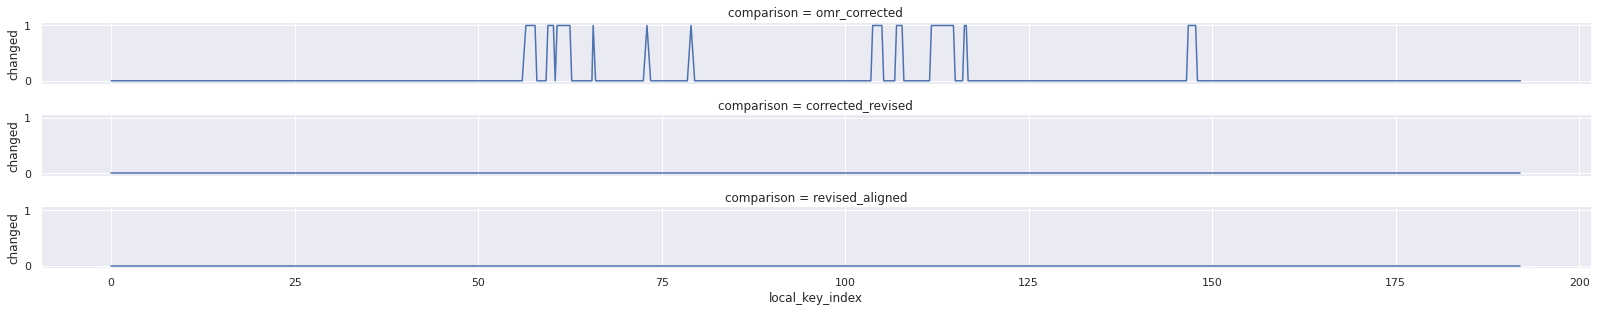

1_op12_4
['c', 'c', 'c', 'c']


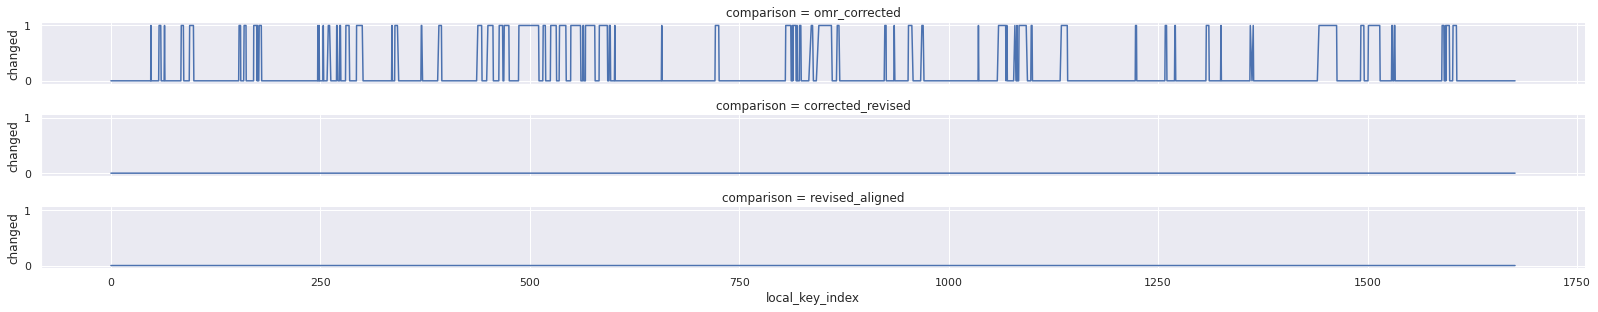

2_op13_1
['A', 'a', 'a', 'a']


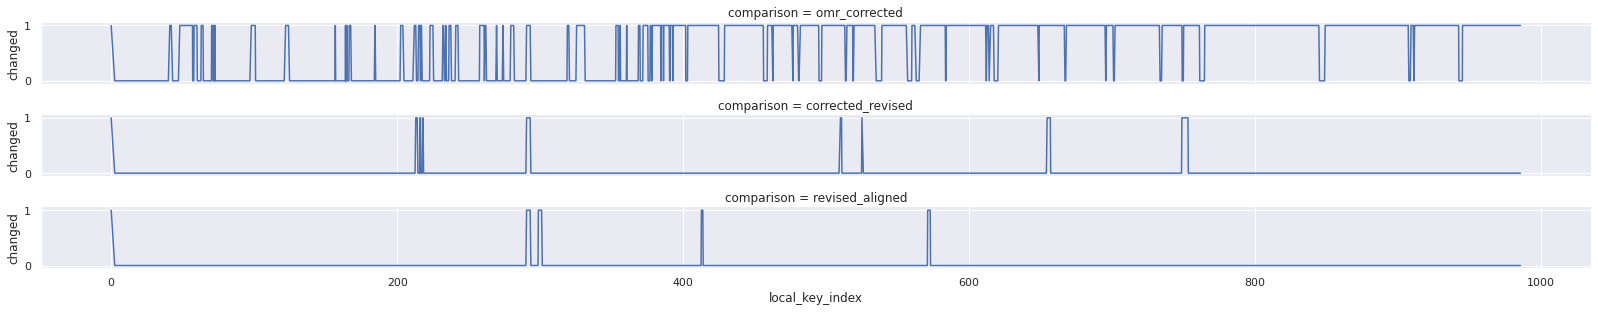

2_op13_2
['F', 'd', 'd', 'd']


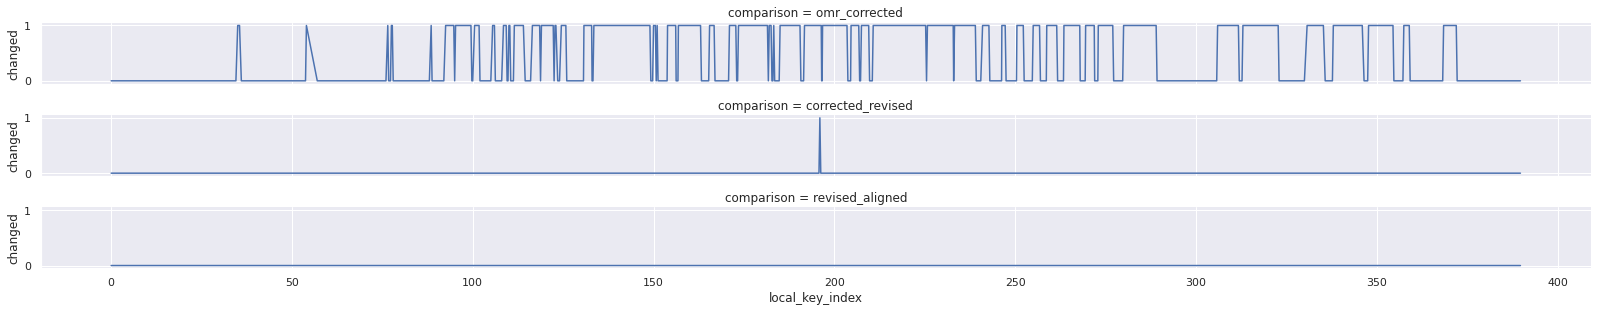

2_op13_3
['a', 'a', 'a', 'a']


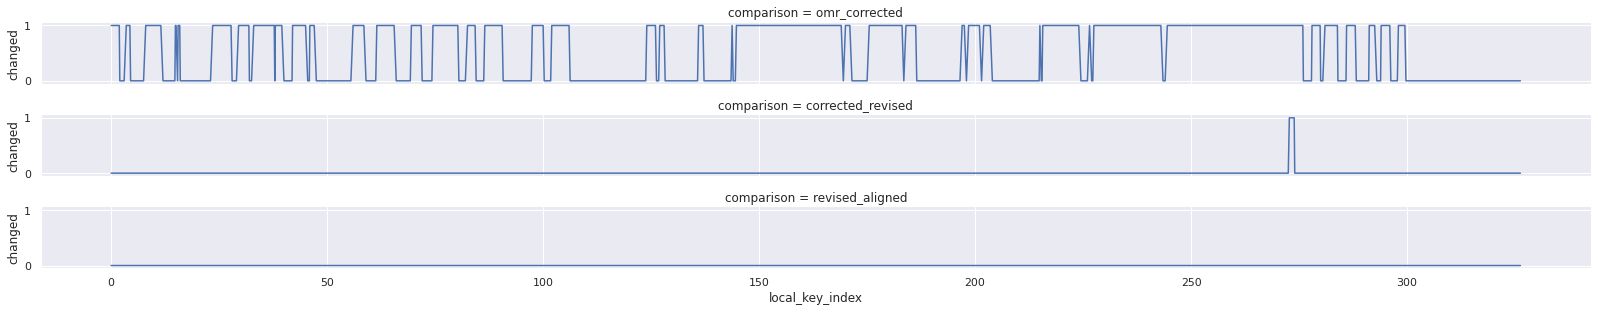

2_op13_4
['a', 'a', 'a', 'a']


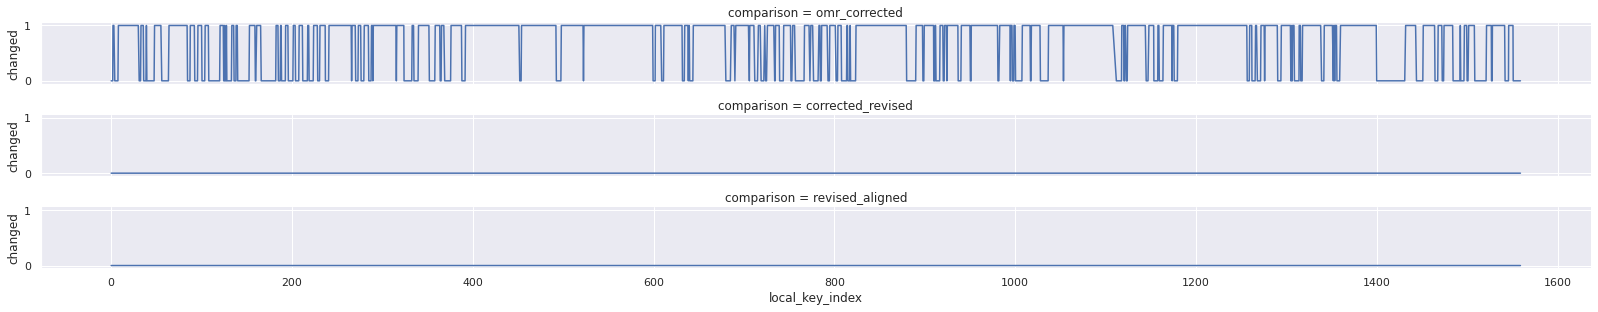

3_op44i_1
['D', 'D', 'D', 'D']


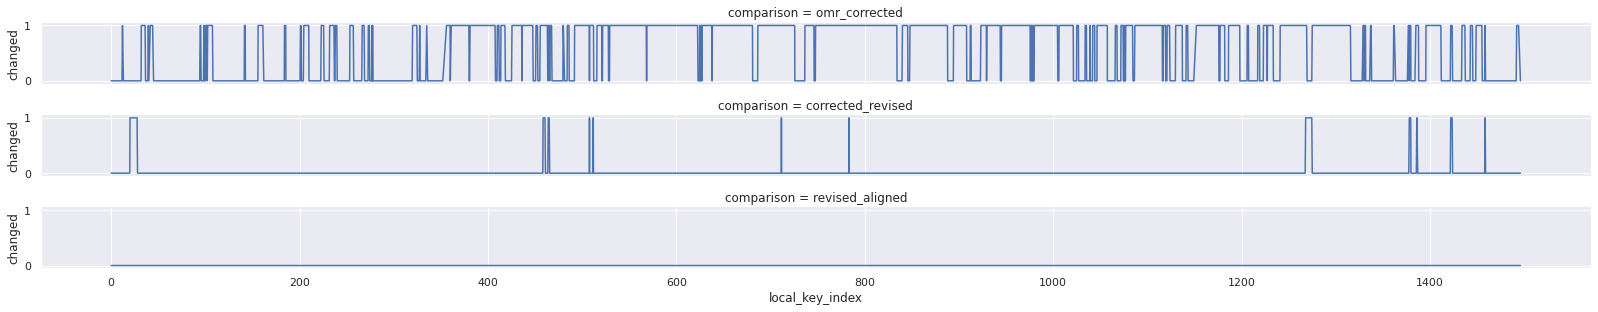

3_op44i_2
['b', 'b', 'b', 'b']


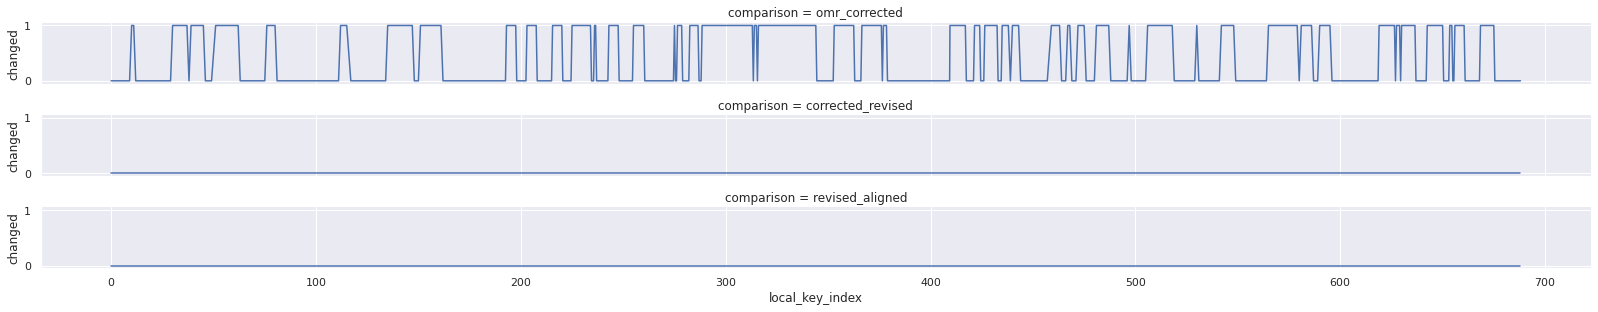

3_op44i_3
['b', 'b', 'b', 'b']


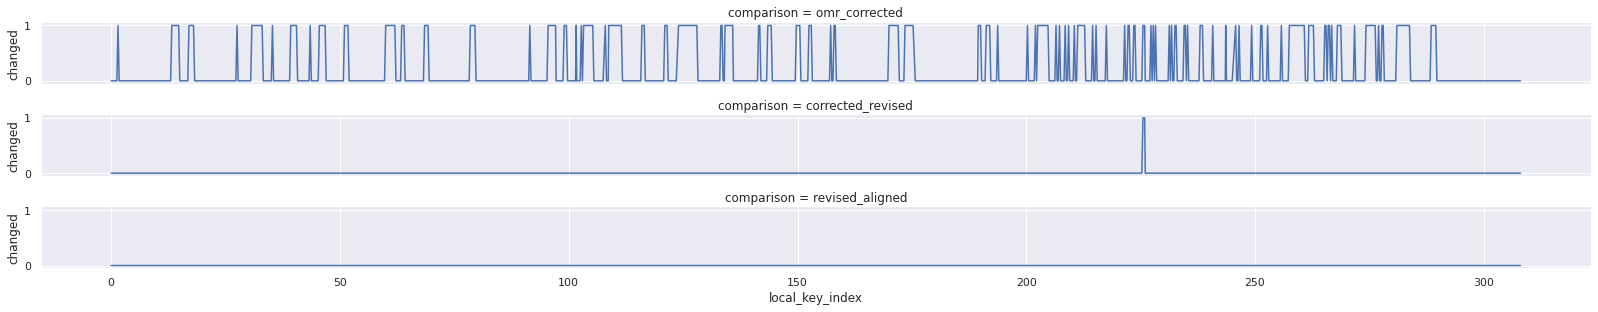

3_op44i_4
['D', 'D', 'D', 'D']


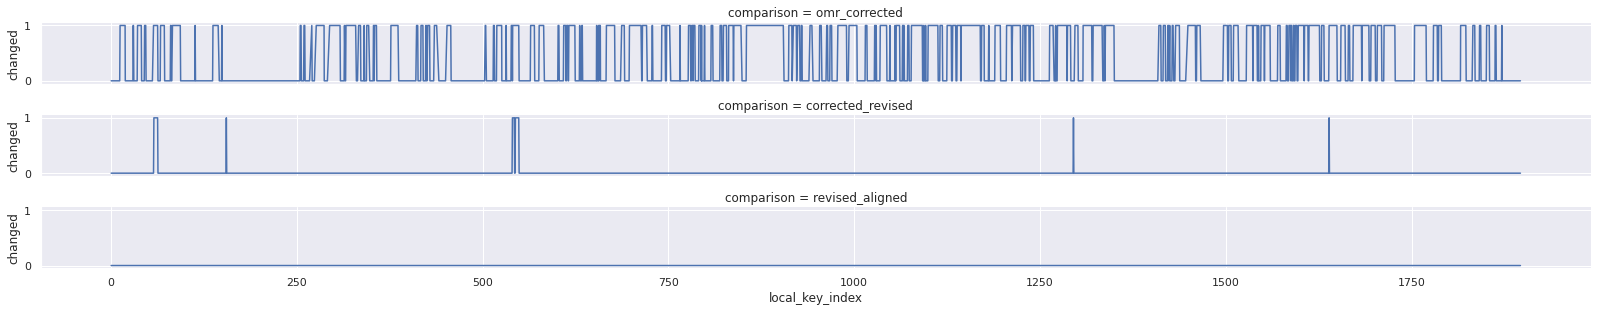

4_op44ii_1
['e', 'e', 'e', 'e']


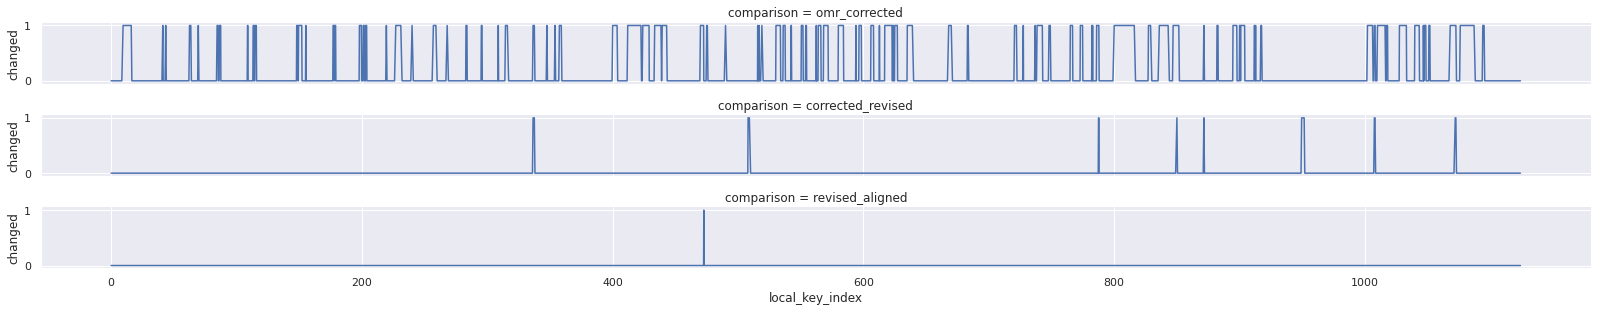

4_op44ii_2
['E', 'E', 'E', 'E']


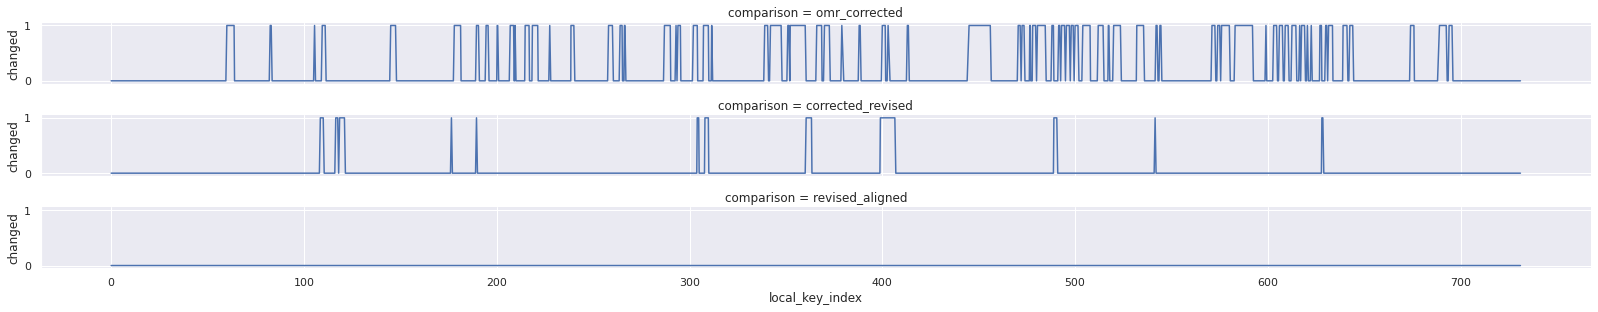

4_op44ii_3
['G', 'G', 'G', 'G']


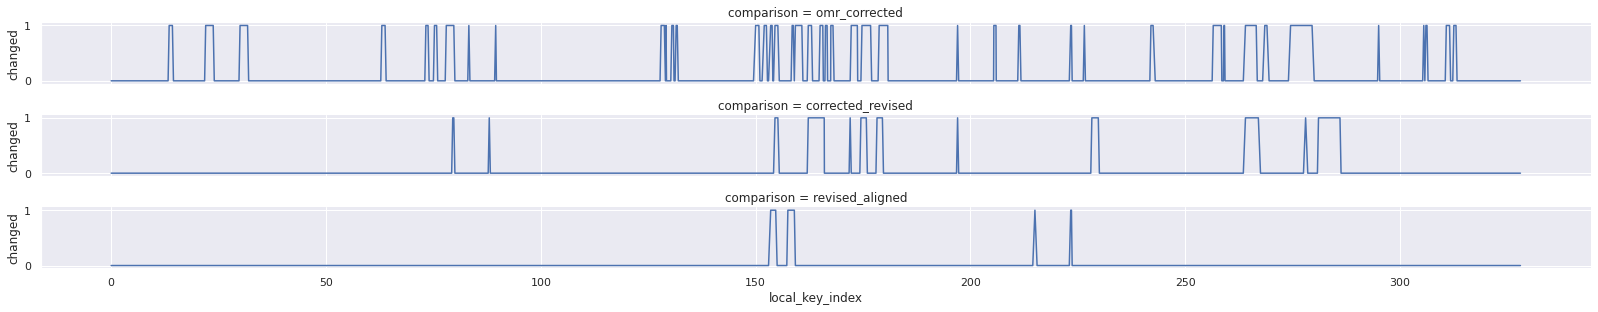

4_op44ii_4
['e', 'e', 'e', 'e']


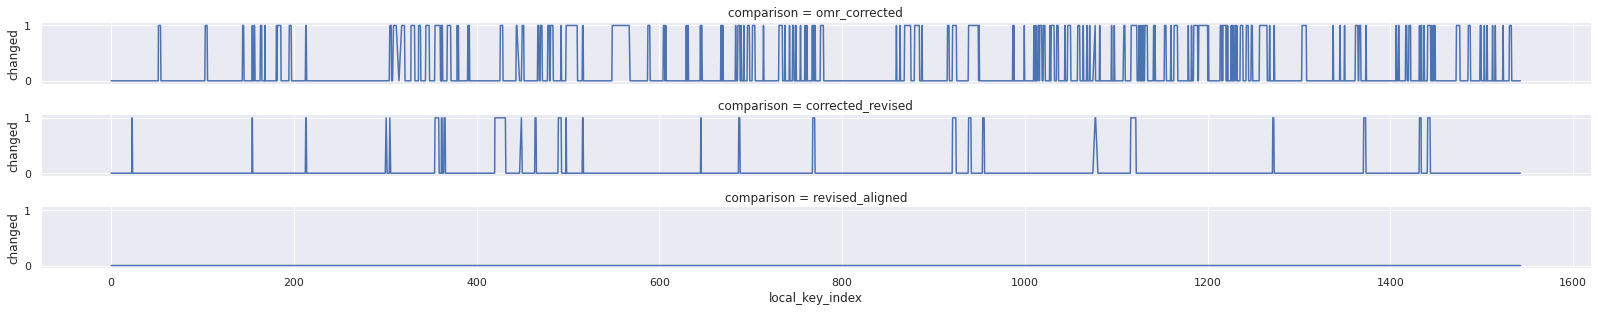

5_op44iii_1
['Eb', 'Eb', 'Eb', 'Eb']


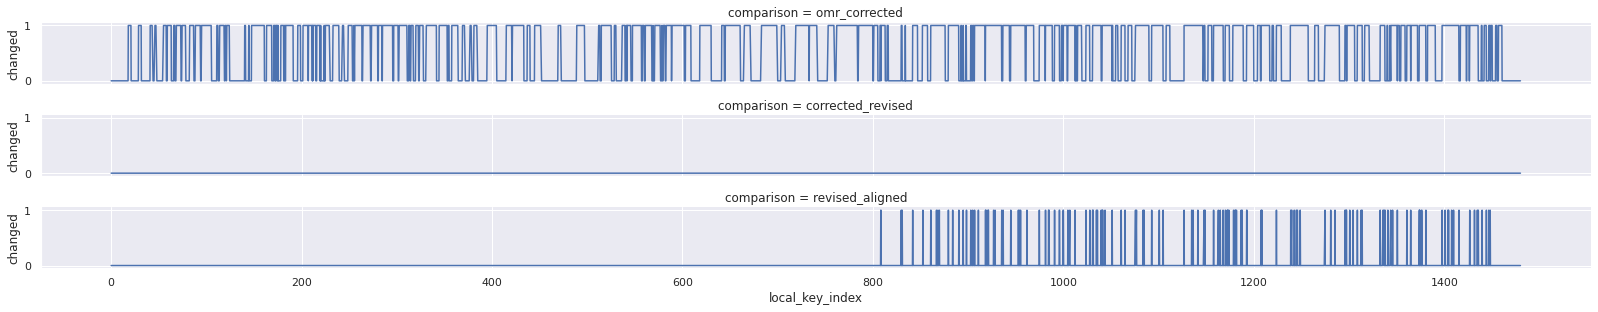

5_op44iii_2
['c', 'c', 'c', 'c']


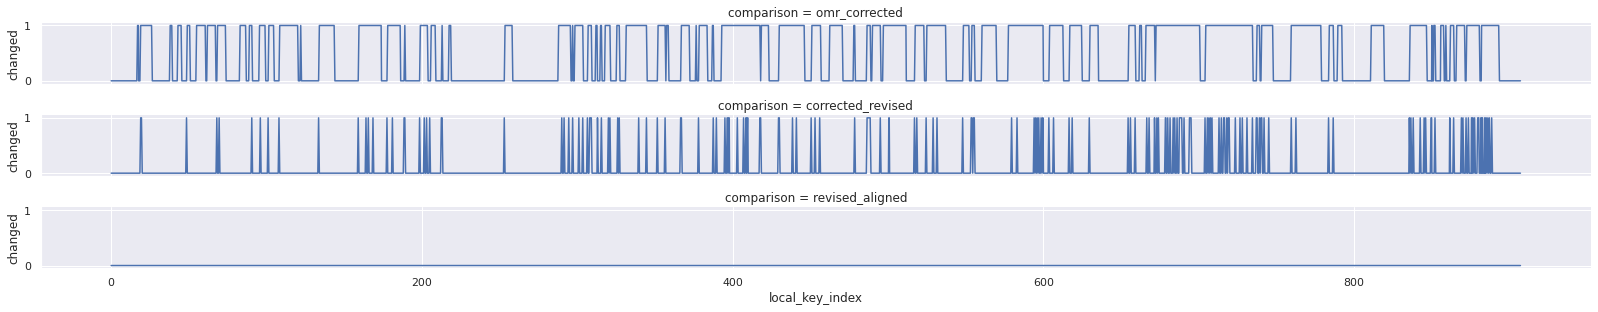

5_op44iii_3
['Ab', 'Ab', 'Ab', 'Ab']


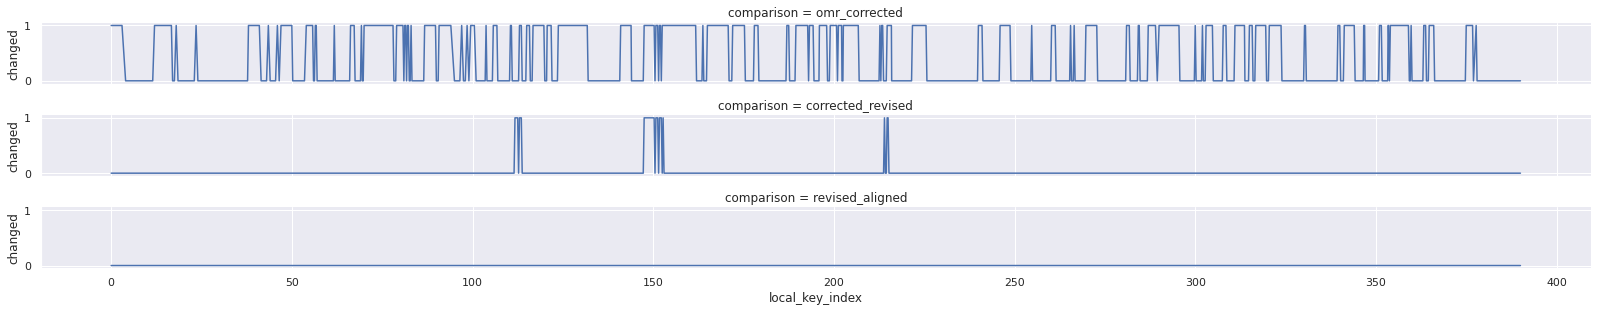

5_op44iii_4
['Eb', 'Eb', 'Eb', 'Eb']


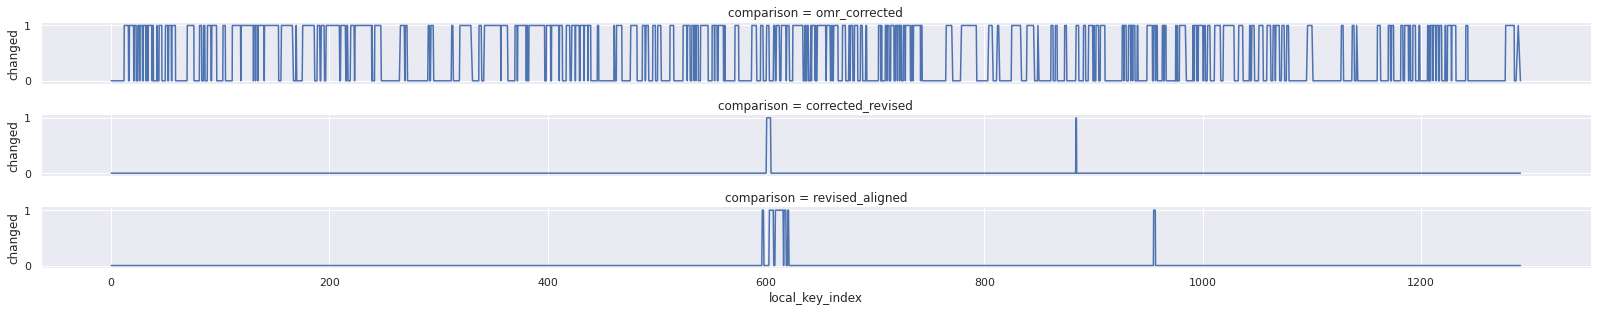

FP_op81_1
['E', 'E', 'E', 'E']


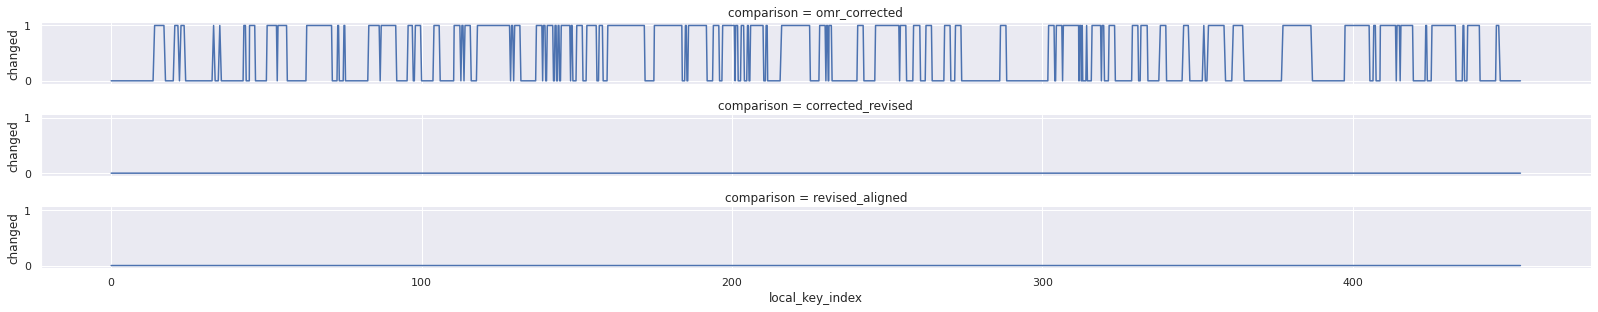

FP_op81_2
['a', 'a', 'a', 'a']


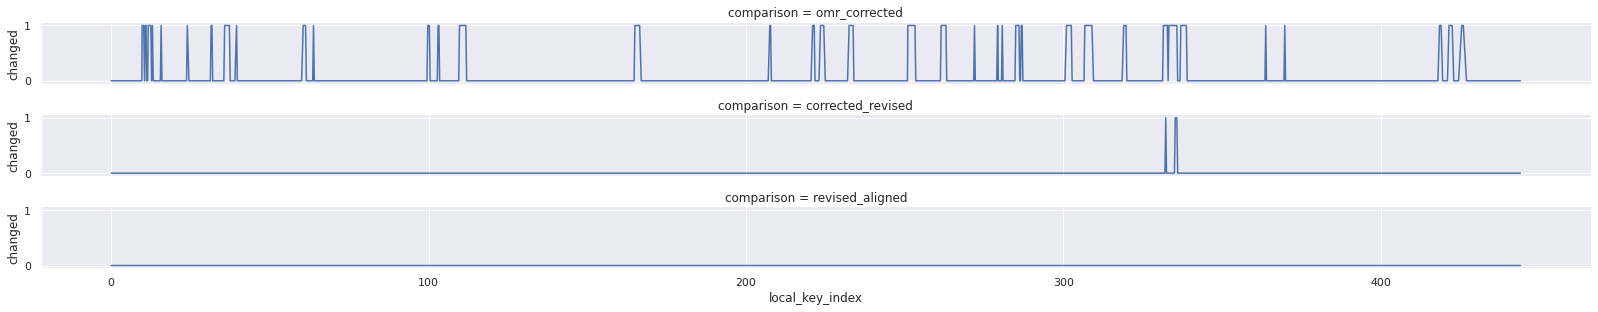

FP_op81_3
['e', 'e', 'e', 'e']


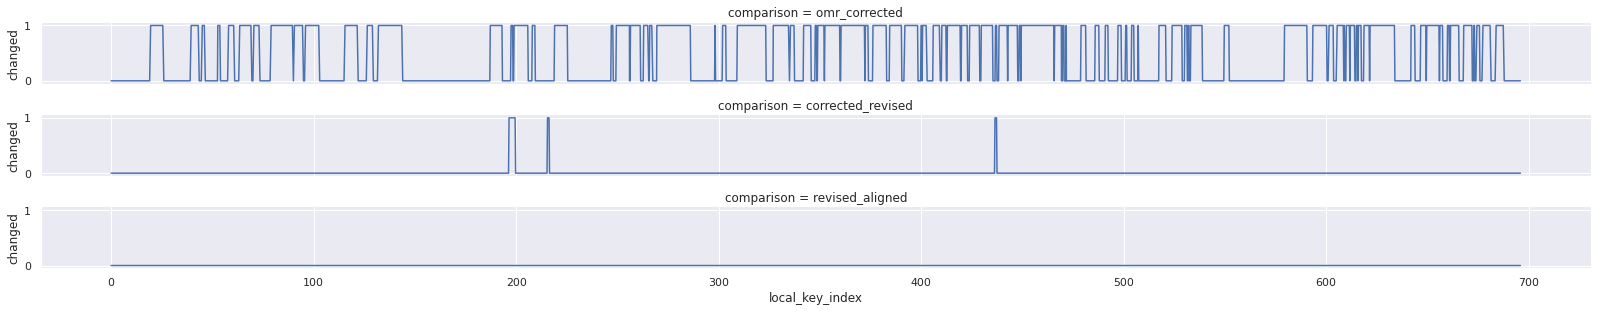

FP_op81_4
['Eb', 'Eb', 'Eb', 'Eb']


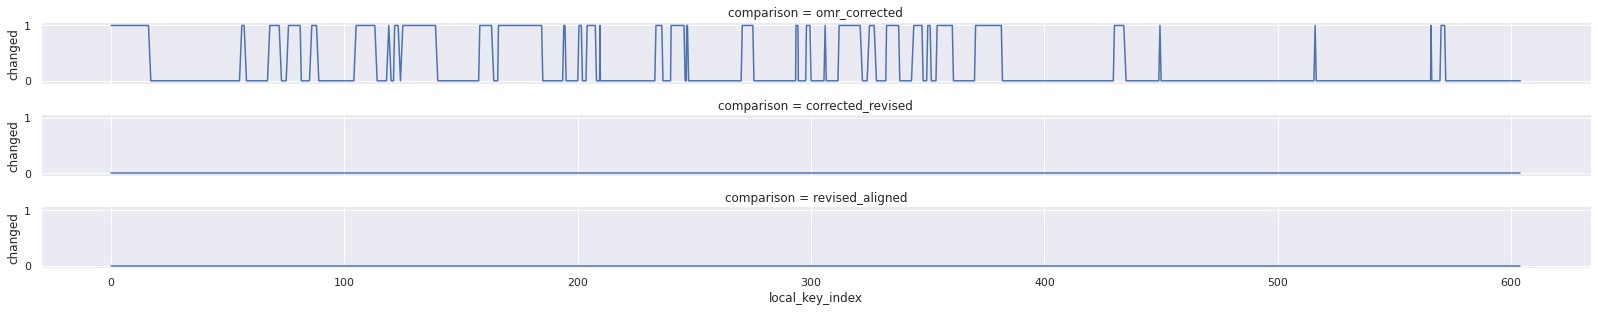

In [19]:
global_key_columns = ['global_key_omr', 'global_key_corrected', 'global_key_revised', 'global_key_aligned']
local_key_columns = ['local_keys_omr', 'local_keys_corrected', 'local_keys_revised', 'local_keys_aligned']
for f, d in analyses_by_file.items():
    print(f)
    df = pd.DataFrame(d, index=d['local_key_index'])
    keys = [df[col][0] for col in global_key_columns]
    df.drop(columns=global_key_columns, inplace=True)
    # Not all stages had the same slices at the same offsets
    # Filling the gaps with the local key of the previous slice    
    df.fillna(method='ffill', inplace=True)
    orders = ['omr_corrected', 'corrected_revised', 'revised_aligned']
    df['omr_corrected'] = (df['local_keys_omr'] != df['local_keys_corrected'])
    df['corrected_revised'] = (df['local_keys_corrected'] != df['local_keys_revised'])
    df['revised_aligned'] = (df['local_keys_revised'] != df['local_keys_aligned'])
    df.drop(columns=local_key_columns, inplace=True)    
    df = df.melt(id_vars=['local_key_index'], value_vars=orders, var_name='comparison', value_name='changed')
    df = df.astype({'changed': 'float64'})
#     df['is_local_key_different'] = df['is_local_key_different'].replace(0.0, np.nan)
    print(keys)
#     plt.figure(figsize=(25, 6))
    
    sns.relplot(
        x='local_key_index', 
        y='changed',
        row='comparison',
        kind='line',
        height=1.5,
        aspect=15.0,
        data=df
    )
    plt.show()    

In [5]:
global_key_columns = ['global_key_omr', 'global_key_corrected', 'global_key_revised', 'global_key_aligned']
local_key_columns = ['local_keys_omr', 'local_keys_corrected', 'local_keys_revised', 'local_keys_aligned']
changes_dict = {}
for f, d in analyses_by_file.items():
    df = pd.DataFrame(d, index=d['local_key_index'])
    keys = [df[col][0] for col in global_key_columns]
    df.drop(columns=global_key_columns, inplace=True)
    # Not all stages had the same slices at the same offsets
    # Filling the gaps with the local key of the previous slice    
    df.fillna(method='ffill', inplace=True)
    omr_to_corrected = (df['local_keys_omr'] != df['local_keys_corrected'])
    omr_to_corrected_change = 100.0 * omr_to_corrected.sum() / df.index.size
    corrected_to_revised = (df['local_keys_corrected'] != df['local_keys_revised'])
    corrected_to_revised_change = 100.0 * corrected_to_revised.sum() / df.index.size
    revised_to_aligned = (df['local_keys_revised'] != df['local_keys_aligned'])
    revised_to_aligned_change = 100.0 * revised_to_aligned.sum() / df.index.size
    
#     print(f'global keys: {keys}')    
#     print(f'C0 to C1 (change): {100.0 * omr_to_corrected.sum() / df.index.size}%')
#     print(f'C1 to C2 (change): {100.0 * corrected_to_revised.sum() / df.index.size}%')
#     print(f'C2 to C3 (change): {100.0 * revised_to_aligned.sum() / df.index.size}%')
    changes_dict[f] = {
        'C0_to_C1': omr_to_corrected_change,
        'C1_to_C2': corrected_to_revised_change,
        'C2_to_C3': revised_to_aligned_change
    }
dfresults = pd.DataFrame(changes_dict).transpose()

In [12]:
for col in dfresults.columns:
    print(col)
    print(f'{dfresults[col].median()} [{dfresults[col].min()} {dfresults[col].max()}]')
dfresults

C0_to_C1
46.8419890478714 [9.91350632069195 71.15655853314527]
C1_to_C2
0.441695322014471 [0.0 9.801876955161626]
C2_to_C3
0.0 [0.0 3.01061295213342]


,C0_to_C1,C1_to_C2,C2_to_C3
1_op12_1,36.250000,0.625000,0.000000
1_op12_2,52.941176,0.000000,0.000000
1_op12_3,10.159363,0.000000,0.000000
1_op12_4,18.704538,0.000000,0.000000
2_op13_1,67.142291,1.585414,0.951249
2_op13_2,57.132513,0.072411,0.000000
2_op13_3,53.314394,0.568182,0.000000
2_op13_4,71.156559,0.000000,0.000000
3_op44i_1,63.768467,1.210947,0.000000
3_op44i_2,49.509804,0.000000,0.000000


An older version of the previous code, kept for future consultation.
```python
global_key_columns = ['global_key_omr', 'global_key_corrected', 'global_key_revised', 'global_key_aligned']
local_key_columns = ['local_keys_omr', 'local_keys_corrected', 'local_keys_revised', 'local_keys_aligned']
for f, d in analyses_by_file.items():
    print(f)
    df = pd.DataFrame(d, index=d['local_key_index'])
    keys = [df[col][0] for col in global_key_columns]
    df.drop(columns=global_key_columns, inplace=True)
    # Not all stages had the same slices at the same offsets
    # Filling the gaps with the local key of the previous slice    
    df.fillna(method='ffill', inplace=True)
    df = df.rename(columns={k: k.replace('local_keys_', '') for k in local_key_columns})
    orders = ['omr', 'corrected', 'revised', 'aligned']
    df = df.melt(id_vars=['local_key_index'], value_vars=orders, var_name='stage', value_name='local_key')
#     df = df.set_index(df['local_key_index'])    
    print(keys)
    print(df)
    plt.figure(figsize=(25, 6))
    
    sns.lineplot(
        x='local_key_index', 
        y='local_key', 
        hue='stage',
#         size='stage',
#         style='stage',        
        linewidth=6,
#         sizes=[8, 4, 2, 1], 
        data=df        
    )
    plt.show()
```